In this notebook, we will present how to merge datasets in scVI

In [1]:
import os
os.chdir("/home/ec2-user/scVI/")
os.getcwd()

'/home/ec2-user/scVI'

In [2]:
use_cuda = True

from scvi.dataset.dataset import GeneExpressionDataset
from scvi.dataset.pbmc import Dataset10X, PbmcDataset

from scvi.inference.posterior import *
from scvi.metrics.clustering import select_indices_evenly, clustering_scores, entropy_batch_mixing
from scipy import sparse
from scvi.models.vae import VAE
from scvi.inference import UnsupervisedTrainer

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [3]:
from scvi.harmonization.utils_chenling import get_matrix_from_dir,assign_label,run_model
import pandas as pd
from sklearn.preprocessing import scale

In [4]:
count, geneid, cellid = get_matrix_from_dir('cite')
count = count.T.tocsr()
seurat = np.genfromtxt('../cite/cite.seurat.labels', dtype='str', delimiter=',')
cellid = np.asarray([x.split('-')[0] for x in cellid])
labels_map = [0, 0, 1, 2, 3, 4, 5, 6]
labels = seurat[1:, 4]
cell_type = ["CD4 T cells", "NK cells", "CD14+ Monocytes", "B cells", "CD8 T cells", "FCGR3A Monocyte", "na"]
cite = assign_label(cellid, geneid, labels_map, count, cell_type, seurat)

In [5]:
adt_expression_clr = pd.read_csv('../cite/ADT_cut_clr.csv')
dat = [adt_expression_clr.loc[adt_expression_clr['cellid'] == x] for x in seurat[1:,5]]
protein = pd.concat(dat)

In [6]:
cell_types = np.array(["cd4_t_helper", "regulatory_t", "naive_t", "memory_t", "cytotoxic_t", "naive_cytotoxic",
                       "b_cells", "cd34", "cd56_nk", "cd14_monocytes"])
cell_type_name = np.array(["CD4 T cells", "CD4 T cells Regulatory", "CD4 T cells Naive", "CD4 Memory T cells", "CD8 T cells", "CD8 T cells Naive",
                       "B cells", "CD34 cells", "NK cells", "CD14+ Monocytes"])

datasets = []
for i,cell_type in enumerate(cell_types):
    dataset = Dataset10X(cell_type, save_path='data/')
    dataset.cell_types = np.array([cell_type_name[i]])
    dataset.labels = dataset.labels.astype('int')
    dataset.subsample_genes(dataset.nb_genes)
    dataset.gene_names = dataset.gene_symbols
    datasets += [dataset]

pure = GeneExpressionDataset.concat_datasets(*datasets, shared_batches=True)


File data/10X/cd4_t_helper/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 16049 genes
Downsampling from 11213 to 11213 cells
File data/10X/regulatory_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 15950 genes
Downsampling from 10263 to 10263 cells
File data/10X/naive_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 15565 genes
Downsampling from 10479 to 10479 cells
File data/10X/memory_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 16169 genes
Downsampling from 10224 to 10224 cells
File data/10X/cytotoxic_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 16130 genes

In [7]:
# pure.cell_types[pure.cell_types=='CD4 T cells'] = 'CD4 T cell'

In [8]:
len(pure)

94655

In [9]:
donor = Dataset10X('fresh_68k_pbmc_donor_a')
donor.gene_names = donor.gene_symbols

File data/10X/fresh_68k_pbmc_donor_a/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [10]:
import os
if not os.path.isfile('data/10X/fresh_68k_pbmc_donor_a/68k_pbmc_barcodes_annotation.tsv'):
    import urllib.request
    annotation_url = 'https://raw.githubusercontent.com/10XGenomics/single-cell-3prime-paper/master/pbmc68k_analysis/68k_pbmc_barcodes_annotation.tsv'
    urllib.request.urlretrieve(annotation_url, 'data/10X/fresh_68k_pbmc_donor_a/68k_pbmc_barcodes_annotation.tsv')  

annotation = pd.read_csv('data/10X/fresh_68k_pbmc_donor_a/68k_pbmc_barcodes_annotation.tsv',sep='\t')
cellid1 = donor.barcodes
temp = cellid1.join(annotation)
assert all(temp[0]==temp['barcodes'])

donor.cell_types,donor.labels = np.unique(temp['celltype'],return_inverse=True)

In [11]:
print(pure.cell_types)
print(donor.cell_types)
donor.labels = donor.labels.reshape(len(donor.labels),1)
donor.cell_types = np.array([ 'CD14+ Monocytes','B cells','CD34 cells', 'CD4 T cells','CD4 T cells Regulatory', 
                             'CD4 T cells Naive','CD4 Memory T cells','NK cells',
                            'CD8 T cells',  'CD8 T cells Naive', 'Dendritic'])

['CD8 T cells Naive' 'B cells' 'CD4 T cells Naive' 'CD4 T cells'
 'CD34 cells' 'NK cells' 'CD4 Memory T cells' 'CD4 T cells Regulatory'
 'CD14+ Monocytes' 'CD8 T cells']
['CD14+ Monocyte' 'CD19+ B' 'CD34+' 'CD4+ T Helper2' 'CD4+/CD25 T Reg'
 'CD4+/CD45RA+/CD25- Naive T' 'CD4+/CD45RO+ Memory' 'CD56+ NK'
 'CD8+ Cytotoxic T' 'CD8+/CD45RA+ Naive Cytotoxic' 'Dendritic']


In [12]:
gene_dataset = GeneExpressionDataset.concat_datasets(cite,donor, pure)

Keeping 11300 genes


In [13]:
gene_dataset.X.shape

(169850, 11300)

In [14]:
gene_dataset.cell_types

array(['CD8 T cells Naive', 'B cells', 'CD4 T cells Naive', 'CD4 T cells',
       'na', 'CD34 cells', 'NK cells', 'FCGR3A Monocyte',
       'CD4 Memory T cells', 'Dendritic', 'CD4 T cells Regulatory',
       'CD14+ Monocytes', 'CD8 T cells'], dtype='<U22')

In [15]:
# plotname='CiteDonorPure'
# latent, batch_indices, labels, keys, stats = run_model(
#     'writedata', gene_dataset, 0, 0,filename=plotname)

In [16]:
def subsetByGenenames(dataset, subsetnames):
    genenames = dataset.gene_names
    filter = np.asarray([x in subsetnames for x in genenames])
    dataset.X = dataset.X[:, filter]
    dataset.update_genes(np.arange(len(filter))[filter])
    return dataset

def SubsetGenes(dataset1,dataset2,dataset3,gene_dataset,plotname,ngenes=1000):
    import pandas as pd
    genes1 = pd.read_table('../Seurat_data/' + plotname + '.1.hvg_info.csv', delimiter=',')
    geneid1 = np.asarray([x.replace('gene_', '') for x in genes1[genes1.keys()[0]]]).astype('int')
    genenames1 = genes1['genename']
    genes2 = pd.read_table('../Seurat_data/' + plotname + '.2.hvg_info.csv', delimiter=',')
    geneid2 = np.asarray([x.replace('gene_', '') for x in genes2[genes2.keys()[0]]]).astype('int')
    genenames2 = genes2['genename']
    genes3 = pd.read_table('../Seurat_data/' + plotname + '.3.hvg_info.csv', delimiter=',')
    geneid3 = np.asarray([x.replace('gene_', '') for x in genes3[genes3.keys()[0]]]).astype('int')
    genenames3 = genes3['genename']
    assert np.sum(np.asarray(genenames1) == gene_dataset.gene_names) == len(gene_dataset.gene_names)
    assert np.sum(np.asarray(genenames2) == gene_dataset.gene_names) == len(gene_dataset.gene_names)
    assert np.sum(np.asarray(genenames3) == gene_dataset.gene_names) == len(gene_dataset.gene_names)
    geneid = np.union1d(np.union1d(geneid1[:ngenes], geneid2[:ngenes]),geneid3[:ngenes]) - 1
    genes = gene_dataset.gene_names[geneid]
    dataset1 = subsetByGenenames(dataset1,genes)
    dataset2 = subsetByGenenames(dataset2,genes)
    dataset3 = subsetByGenenames(dataset3,genes)
    gene_dataset = subsetByGenenames(gene_dataset,genes)
    return dataset1,dataset2,dataset3,gene_dataset


In [17]:
cite,donor,pure,gene_dataset = SubsetGenes(cite,donor,pure,gene_dataset,'CiteDonorPure')

Downsampling from 17014 to 2071 genes
Downsampling from 6616 to 6616 cells
Downsampling from 32738 to 2071 genes
Downsampling from 68579 to 68579 cells
Downsampling from 11560 to 2071 genes
Downsampling from 94655 to 94655 cells
Downsampling from 11300 to 2071 genes
Downsampling from 169850 to 169850 cells


In [18]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
          n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
# trainer.train(n_epochs=100)
# import torch
# torch.save(trainer.model,'../models/CiteDonorPure.vae.pkl')
trainer.model = torch.load('../models/CiteDonorPure.vae.pkl')

In [19]:
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
# latent, idx_t_sne = trainer.train_set.apply_t_sne(latent, 10000)

In [20]:
from scvi.models.scanvi import SCANVI
from scvi.inference import AlternateSemiSupervisedTrainer,SemiSupervisedTrainer

scanvi = SCANVI(gene_dataset.nb_genes, gene_dataset.n_batches, gene_dataset.n_labels, n_layers=2)
scanvi.load_state_dict(full.model.state_dict(), strict=False)
# trainer_scanvi = SemiSupervisedTrainer(scanvi, gene_dataset, n_epochs_classifier=10, lr_classification=5 * 1e-3)
trainer_scanvi = AlternateSemiSupervisedTrainer(scanvi, gene_dataset, n_epochs_classifier=10, lr_classification=5 * 1e-3)

trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=(gene_dataset.batch_indices == 2))
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(
    indices=(gene_dataset.batch_indices != 2)
)
trainer_scanvi.train(n_epochs=5)
scanvi_posterior = trainer_scanvi.create_posterior(trainer_scanvi.model,gene_dataset,indices=np.arange(len(gene_dataset)))
latent_scanvi, batches, labels = scanvi_posterior.sequential().get_latent()



training: 100%|██████████| 5/5 [04:06<00:00, 49.33s/it]


In [21]:
y,pred_y = scanvi_posterior.sequential().compute_predictions()

In [22]:
batch_indices = batches.ravel()

In [23]:
np.mean(pred_y[batch_indices==0] == y[batch_indices==0])

0.5012091898428053

In [24]:
set(np.unique(y[batch_indices==0])).intersection(set(np.unique(y[batch_indices==2])))

{1, 3, 6, 11, 12}

In [25]:
np.mean(pred_y[batch_indices==2] == y[batch_indices==2])

0.7170461148380962

In [26]:
[np.mean(pred_y[(batch_indices==2) * (y==i)]==i) for i in [1, 3, 4, 7, 10]]

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.9985126425384234, 0.0, nan, nan, 0.8958394231706129]

In [27]:
[np.mean(pred_y[(batch_indices==0) * (y==i)]==i) for i in [1, 3, 4, 7, 10]]

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.9883211678832117, 0.0, 0.0, 0.0, nan]

In [28]:
gene_dataset.cell_types[10]

'CD4 T cells Regulatory'

In [29]:

scanvi_cite = SCANVI(gene_dataset.nb_genes, gene_dataset.n_batches, gene_dataset.n_labels, n_layers=2)
scanvi_cite.load_state_dict(full.model.state_dict(), strict=False)
trainer_scanvi_cite = AlternateSemiSupervisedTrainer(scanvi_cite, gene_dataset, n_epochs_classifier=10, lr_classification=5 * 1e-3)

trainer_scanvi_cite.labelled_set   = trainer_scanvi_cite.create_posterior(indices=(gene_dataset.batch_indices.ravel() == 0))
trainer_scanvi_cite.unlabelled_set = trainer_scanvi_cite.create_posterior(indices=(gene_dataset.batch_indices.ravel() != 0))
trainer_scanvi_cite.train(n_epochs=5)
scanvi_cite_posterior = trainer_scanvi_cite.create_posterior(trainer_scanvi_cite.model,gene_dataset,indices=np.arange(len(gene_dataset)))


training: 100%|██████████| 5/5 [03:26<00:00, 41.25s/it]


In [30]:
latent_scanvi_cite, batch_indices, labels = scanvi_cite_posterior.sequential().get_latent()
y,pred_y = scanvi_cite_posterior.sequential().compute_predictions()

In [31]:
batch_indices = batch_indices.ravel()

In [32]:
[np.mean(pred_y[batch_indices==2] == y[batch_indices==2]), np.mean(pred_y[batch_indices==0] == y[batch_indices==0])]

[0.724568168612329, 0.5110338573155986]

In [33]:
set(np.unique(y[batch_indices==0])).intersection(set(np.unique(y[batch_indices==2])))

{1, 3, 6, 11, 12}

In [34]:
y2=y[batch_indices==2]
pred_y2 = pred_y[batch_indices==2]

In [35]:
y0=y[batch_indices==0]
pred_y0 = pred_y[batch_indices==0]

In [36]:
np.mean([y2[i]==pred_y2[i] for i in range(len(y2)) if y2[i] in [1,3,4,7,10] ])

0.6226355311935616

In [37]:
np.mean([y0[i]==pred_y0[i] for i in range(len(y0)) if y0[i] in [1,3,4,7,10] ])

0.17934495509772846

In [38]:
np.mean([y2[i]==pred_y2[i] for i in range(len(y2)) if y2[i] in [1,3,4,7] ])

0.4727204432341065

In [39]:
np.mean([y0[i]==pred_y0[i] for i in range(len(y0)) if y0[i] in [1,3,4,7] ])

0.17934495509772846

In [40]:
[np.mean(pred_y[(batch_indices==0) * (y==i)]==i) for i in [1, 3, 4, 7, 10]]

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.9912408759124087, 0.0, 0.0, 0.0, nan]

In [41]:
gene_dataset.cell_types

array(['CD8 T cells Naive', 'B cells', 'CD4 T cells Naive', 'CD4 T cells',
       'na', 'CD34 cells', 'NK cells', 'FCGR3A Monocyte',
       'CD4 Memory T cells', 'Dendritic', 'CD4 T cells Regulatory',
       'CD14+ Monocytes', 'CD8 T cells'], dtype='<U22')

In [42]:
gene_dataset.labels.ravel==y

array([False, False, False, ..., False, False, False])

In [43]:
np.unique(y[batch_indices==1])

array([ 0,  1,  2,  3,  5,  6,  8,  9, 10, 11, 12])

In [44]:
np.unique(y[batch_indices==1])

array([ 0,  1,  2,  3,  5,  6,  8,  9, 10, 11, 12])

In [45]:
batch_indices = batch_indices.ravel()
np.unique(batch_indices)

array([0, 1, 2])

In [108]:
from scvi.metrics.clustering import select_indices_evenly
from sklearn.manifold import TSNE
import seaborn as sns

citeidx = np.arange(len(batch_indices))[batch_indices==0]
sample = np.unique(np.concatenate([select_indices_evenly(2000, labels),np.arange(len(batch_indices))[batch_indices==0]]))

In [109]:
colors = sns.color_palette('tab20')
latent_s = latent_scanvi[sample, :]
label_s = labels[sample]
batch_s = batch_indices[sample]
imputed_s = full.sequential().imputation()[sample, :]
express_s = gene_dataset.X[sample].A

In [110]:
from umap import UMAP
latent_u = UMAP(spread=2).fit_transform(latent_s)

## let us look at the UMAP

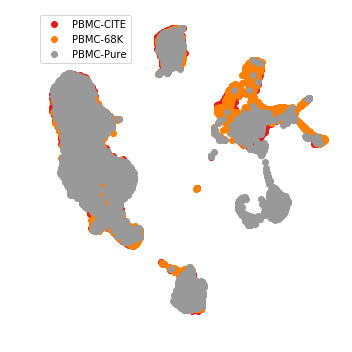

In [111]:
fig=plt.figure(figsize=(5, 5), facecolor='w', edgecolor='k')
cm = matplotlib.cm.get_cmap('Set1')
label_list = ["PBMC-CITE", "PBMC-68K", "PBMC-Pure"]
for i in np.unique(batch_s):
    plt.scatter(latent_u[batch_s == i, 0], latent_u[batch_s == i, 1], c=cm(i * 1.0 / 2), label=label_list[i])
plt.axis("off")
plt.tight_layout()
plt.legend()
plt.savefig("figures/Legend_batch_cite_donor.pdf", transparency=True)

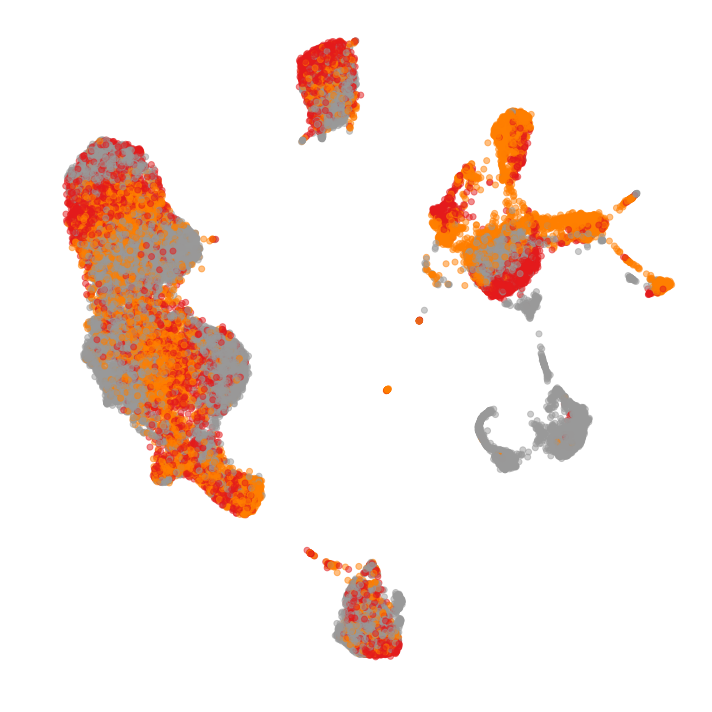

In [112]:
fig=plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
label_list = ["PBMC-CITE", "PBMC-68K", "PBMC-Pure"]
ind = np.random.permutation(np.arange(latent_u.shape[0]))
plt.scatter(latent_u[ind][:, 0], latent_u[ind][:, 1], c=batch_s[ind], cmap= matplotlib.cm.get_cmap('Set1'),alpha=0.5)
plt.axis("off")
plt.tight_layout()
plt.savefig("figures/batch_cite_donor.pdf", transparency=True)

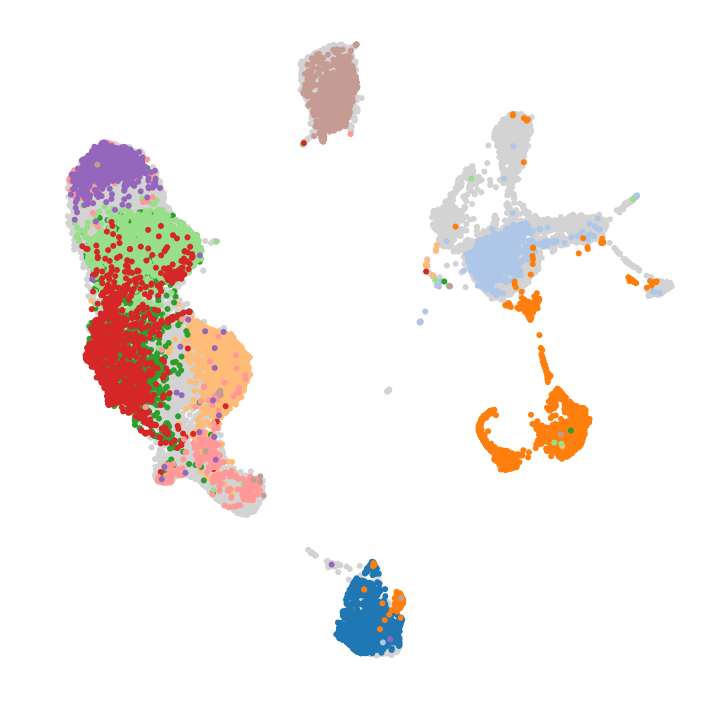

In [118]:
keys = gene_dataset.cell_types
key_order = np.argsort(keys)
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(latent_u[batch_s!=2, 0], latent_u[batch_s!=2, 1], c='lightgrey',
        edgecolors='none')
# ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
for i,k in enumerate(key_order):
    if keys[k]!='unlabelled' and keys[k]!='na':
        idx = (label_s==k).astype('int') * (batch_s==2).astype('int') ==1 
        ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none')
#         ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/pure_lab_cite_donor.pdf", transparency=True)

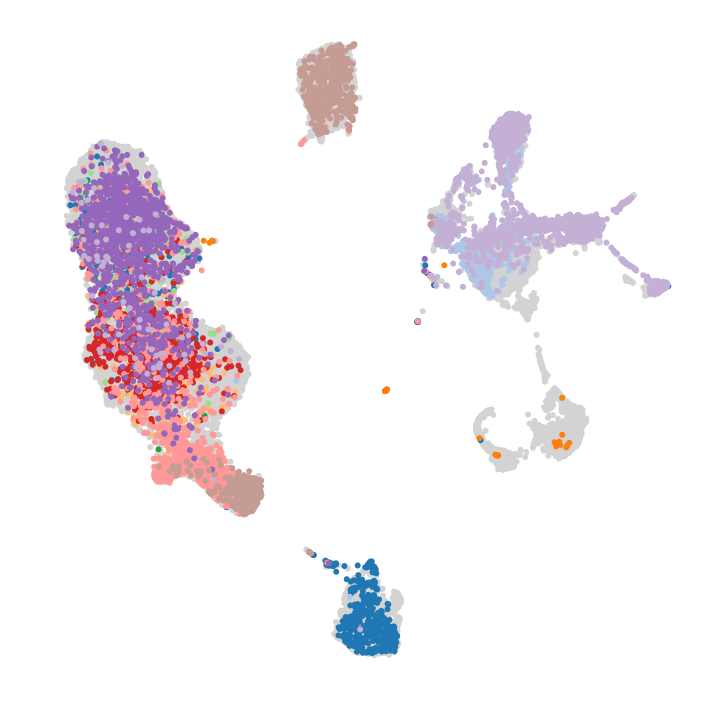

In [119]:
keys = gene_dataset.cell_types
key_order = np.argsort(keys)
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(latent_u[batch_s!=1, 0], latent_u[batch_s!=1, 1], c='lightgrey',
        edgecolors='none')
# ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
for i,k in enumerate(key_order):
    if keys[k]!='unlabelled' and keys[k]!='na':
        idx = (label_s==k).astype('int') * (batch_s==1).astype('int') ==1 
        ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none')
#         ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/10x_label_cite_donor.pdf", transparency=True)

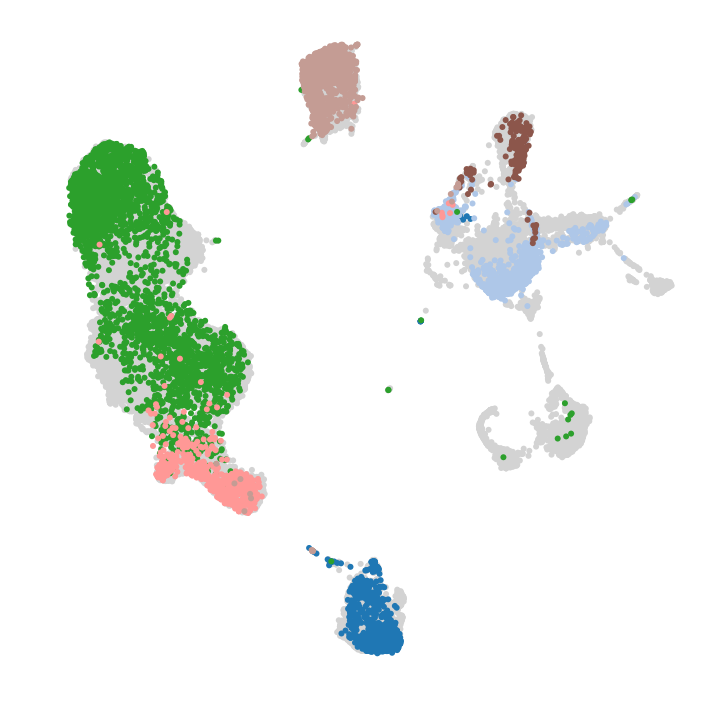

In [117]:
keys = gene_dataset.cell_types
key_order = np.argsort(keys)
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(latent_u[batch_s!=0, 0], latent_u[batch_s!=0, 1], c='lightgrey', label=keys[k],
        edgecolors='none')
# ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
for i,k in enumerate(key_order):
    if keys[k]!='unlabelled' and keys[k]!='na':
        idx = (label_s==k).astype('int') * (batch_s==0).astype('int') ==1 
        ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none')
#         ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/CITE_cite_donor.pdf", transparency=True)

In [54]:
protein = np.load("../cite/cite.prot.npy")
normalized_protein = np.zeros_like(protein)

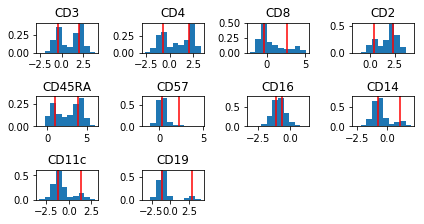

In [55]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2)
for i, marker in enumerate(['CD3', 'CD4', 'CD8', 'CD2', 'CD45RA', 'CD57', 'CD16', 'CD14', 'CD11c', 'CD19']):
    plt.subplot(4,4, 1 + i)
    gmm.fit(protein[:, i].reshape((-1, 1)))
    mean_1, mean_2 = gmm.means_[0], gmm.means_[1] 
    plt.hist(protein[:, i], density=True)
    plt.axvline(mean_1, c="r")
    plt.axvline(mean_2, c="r")
    plt.title(marker)
    normalized_protein[:, i] = np.copy(protein[:, i])
    cutoff = 0.5 * (mean_1 + mean_2)
    normalized_protein[:, i] -= cutoff
    normalized_protein[:, i][normalized_protein[:, i] <= 0] = 0
    normalized_protein[:, i] /= np.max(normalized_protein[:, i])
plt.tight_layout()
plt.show()

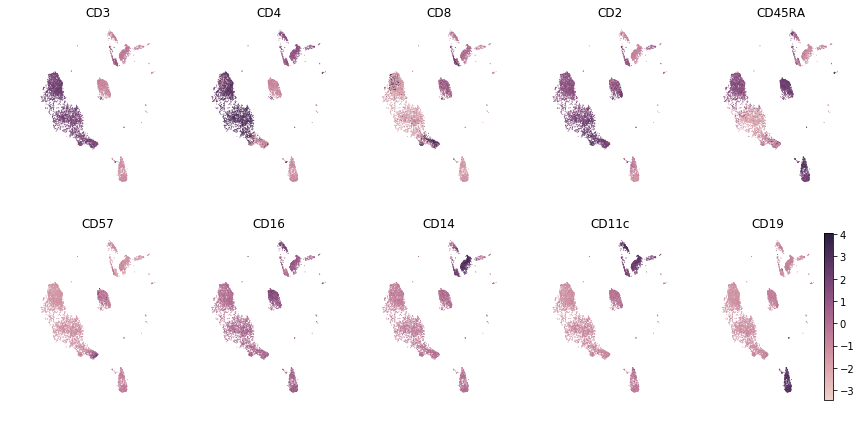

In [56]:
# protein = np.load("../cite/cite.prot.npy")
# print(protein.columns.values)
plt.figure(figsize=(12, 6), facecolor='w', edgecolor='k')
for i, marker in enumerate(['CD3', 'CD4', 'CD8', 'CD2', 'CD45RA', 'CD57', 'CD16', 'CD14', 'CD11c', 'CD19']):
    plt.subplot(2, 5, i+1)
    batch_s = batch_s.ravel()
    plt.scatter(latent_u[np.arange(len(cite)), 0], latent_u[np.arange(len(cite)), 1], 
                c=np.asarray(protein[:, i]), cmap = sns.cubehelix_palette(as_cmap=True),edgecolors='none',s=0.8)
    plt.axis("off")
    plt.tight_layout()
    plt.title(marker)
plt.colorbar()
plt.savefig("figures/protein_cite_donor.pdf", transparency=True)

## Clustering of donor wronly assigned

In [57]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
#clustering = KMeans(init='k-means++', n_clusters=5, n_init=30, n_jobs=10)
clustering = DBSCAN(eps=0.6, min_samples=50)
#clustering = SpectralClustering(n_clusters=5, n_jobs=-1, affinity ="nearest_neighbors")
%time clusters = clustering.fit_predict(latent_u)
latent_s.shape, clusters.shape, np.unique(clusters, return_counts=True)

CPU times: user 508 ms, sys: 4 ms, total: 512 ms
Wall time: 511 ms


((27612, 10),
 (27612,),
 (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]),
  array([  247,  2364,  2568,  3552,   158, 15711,  1161,  1011,   284,
           556])))

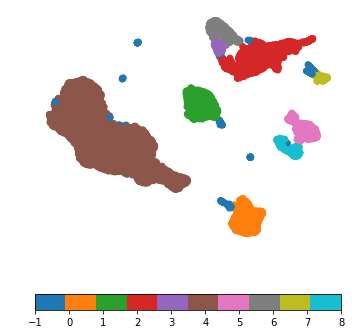

In [58]:
plt.figure(figsize=(5, 5))
plt.scatter(latent_u[:, 0], latent_u[:, 1], c=clusters, cmap=plt.cm.get_cmap("tab10"))
plt.axis("off")
plt.colorbar(orientation="horizontal")
plt.tight_layout()
plt.show()

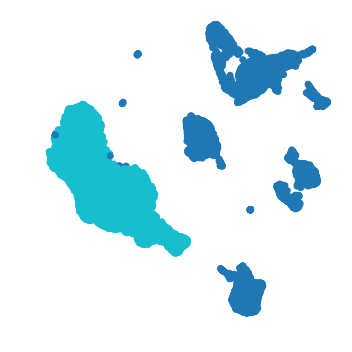

In [59]:
plt.figure(figsize=(5, 5))
T_cell_id = np.bincount(clusters[label_s == np.where(gene_dataset.cell_types =='CD4 T cells')[0][0]]+1).argmax()-1
plt.scatter(latent_u[:, 0], latent_u[:, 1], c=clusters==T_cell_id, cmap=plt.cm.get_cmap("tab10"))
plt.axis("off")
plt.tight_layout()
plt.show()

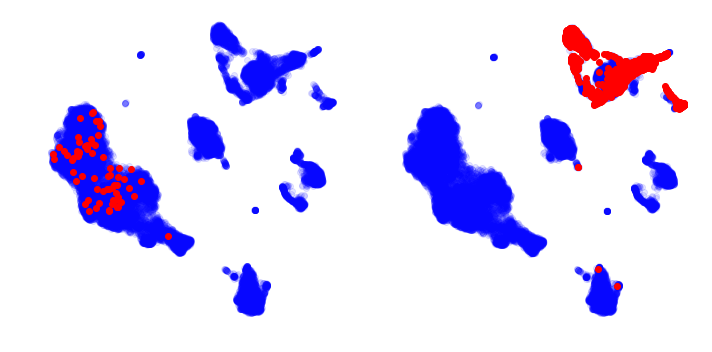

In [60]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
false_DC = np.logical_and(label_s == np.where(gene_dataset.cell_types =='Dendritic')[0][0], batch_s == 1 )
false_DC = np.logical_and(false_DC, clusters==T_cell_id)
plt.scatter(latent_u[np.logical_not(false_DC), 0], latent_u[np.logical_not(false_DC), 1], color="b", alpha=0.1)
plt.scatter(latent_u[false_DC, 0], latent_u[false_DC, 1], color="r")
plt.axis("off")
plt.subplot(1, 2, 2)
control_DC = np.logical_and(label_s == np.where(gene_dataset.cell_types =='Dendritic')[0][0], batch_s == 1 )
control_DC = np.logical_and(control_DC, clusters!=T_cell_id)
plt.scatter(latent_u[np.logical_not(control_DC), 0], latent_u[np.logical_not(control_DC), 1], color="b", alpha=0.1)
plt.scatter(latent_u[control_DC, 0], latent_u[control_DC, 1], color="r")
plt.axis("off")
plt.tight_layout()
plt.show()

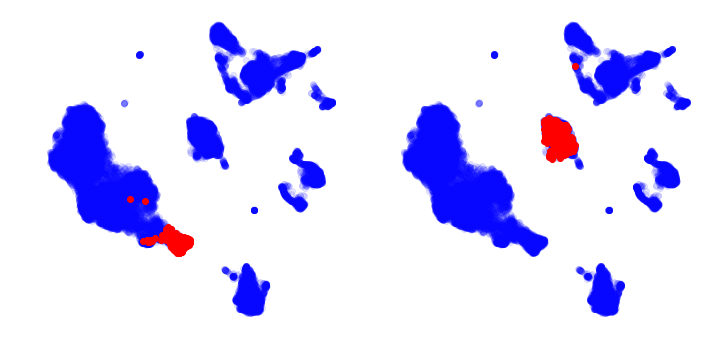

In [61]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
false_NK = np.logical_and(label_s == np.where(gene_dataset.cell_types =='NK cells')[0][0], batch_s == 1 )
false_NK = np.logical_and(false_NK, clusters==T_cell_id)
plt.scatter(latent_u[np.logical_not(false_NK), 0], latent_u[np.logical_not(false_NK), 1], color="b", alpha=0.1)
plt.scatter(latent_u[false_NK, 0], latent_u[false_NK, 1], color="r")
plt.axis("off")
plt.subplot(1, 2, 2)
control_NK = np.logical_and(label_s == np.where(gene_dataset.cell_types =='NK cells')[0][0], batch_s == 1 )
control_NK = np.logical_and(control_NK, clusters!=T_cell_id)
control_NK = np.logical_and(control_NK, clusters!=-1)
plt.scatter(latent_u[np.logical_not(control_NK), 0], latent_u[np.logical_not(control_NK), 1], color="b", alpha=0.1)
plt.scatter(latent_u[control_NK, 0], latent_u[control_NK, 1], color="r")
plt.axis("off")
plt.tight_layout()
plt.show()

In [58]:
genenames = gene_dataset.gene_names

In [74]:
DC_s = np.random.choice(np.where(control_DC)[0],np.sum(false_DC))

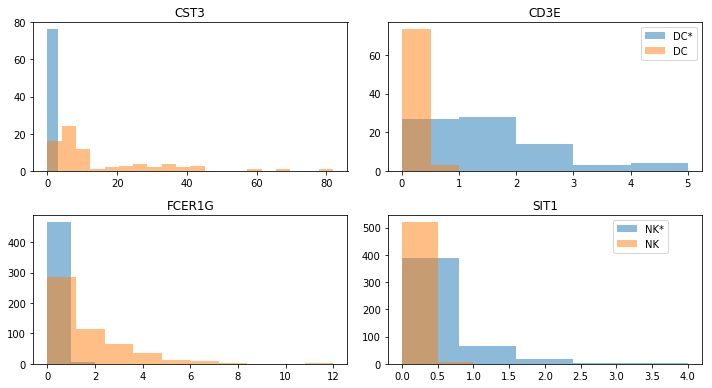

In [108]:
plt.figure(figsize=(10, 5.5))
plt.subplot(2, 2, 1)
plt.hist(express_s[false_DC,genenames=='CST3'], 1,alpha=0.5, label='DC*')
plt.hist(express_s[DC_s,genenames=='CST3'], 20 ,alpha=0.5, label='DC')
plt.title('CST3')
plt.subplot(2, 2, 2)
plt.hist(express_s[false_DC,genenames=='CD3E'],5, alpha=0.5, label='DC*')
plt.hist(express_s[DC_s,genenames=='CD3E'],2,alpha=0.5, label='DC')
plt.legend(loc='upper right',bbox_to_anchor=(1, 1))
plt.title('CD3E')
plt.subplot(2, 2, 3)
plt.hist(express_s[false_NK,genenames=='FCER1G'], 2, alpha=0.5, label='NK*')
plt.hist(express_s[control_NK,genenames=='FCER1G'], 10, alpha=0.5, label='NK')
plt.title('FCER1G')
plt.subplot(2, 2, 4)
plt.hist(express_s[false_NK,genenames=='SIT1'], 5, alpha=0.5, label='NK*')
plt.hist(express_s[control_NK,genenames=='SIT1'], 2, alpha=0.5, label='NK')
plt.legend(loc='upper left',bbox_to_anchor=(0.7, 1))
plt.title('SIT1')
plt.tight_layout()
plt.savefig('mislabelled_rawcounts.pdf', transparency=True)


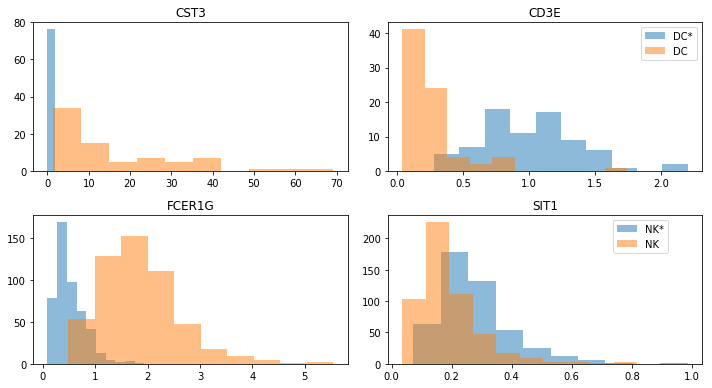

In [112]:
plt.figure(figsize=(10, 5.5))
plt.subplot(2, 2, 1)
plt.hist(imputed_s[false_DC,genenames=='CST3'], 1,alpha=0.5, label='DC*')
plt.hist(imputed_s[DC_s,genenames=='CST3'], 10 ,alpha=0.5, label='DC')
plt.title('CST3')
plt.subplot(2, 2, 2)
plt.hist(imputed_s[false_DC,genenames=='CD3E'],10, alpha=0.5, label='DC*')
plt.hist(imputed_s[DC_s,genenames=='CD3E'],10,alpha=0.5, label='DC')
plt.legend(loc='upper right',bbox_to_anchor=(1, 1))
plt.title('CD3E')
plt.subplot(2, 2, 3)
plt.hist(imputed_s[false_NK,genenames=='FCER1G'], 10, alpha=0.5, label='NK*')
plt.hist(imputed_s[control_NK,genenames=='FCER1G'], 10, alpha=0.5, label='NK')
plt.title('FCER1G')
plt.subplot(2, 2, 4)
plt.hist(imputed_s[false_NK,genenames=='SIT1'], 10, alpha=0.5, label='NK*')
plt.hist(imputed_s[control_NK,genenames=='SIT1'], 10, alpha=0.5, label='NK')
plt.legend(loc='upper left',bbox_to_anchor=(0.7, 1))
plt.title('SIT1')
plt.tight_layout()
plt.savefig('mislabelled_imputed.pdf', transparency=True)


# Protein FACS correspondance

In [62]:
from sklearn.neighbors import NearestNeighbors
# 10 nearest neighbor in citeseq from each cell in pure population
nbrs = NearestNeighbors(n_neighbors=3 + 1).fit(latent_s[batch_s==0,:])
indices = nbrs.kneighbors(latent_s[batch_s==2,:], return_distance=False)[:, 1:]

In [63]:
celltypes2 = keys[np.unique(label_s[batch_s==2])]
celltype_order = np.argsort(celltypes2)

In [64]:
protein=[]
for j in np.unique(label_s[batch_s==2])[celltype_order]:
    idx = indices[label_s[batch_s==2] == j]
    clr = normalized_protein[idx.ravel()]
    protein.append(np.mean(clr,axis=0))

protein = np.asarray(protein)

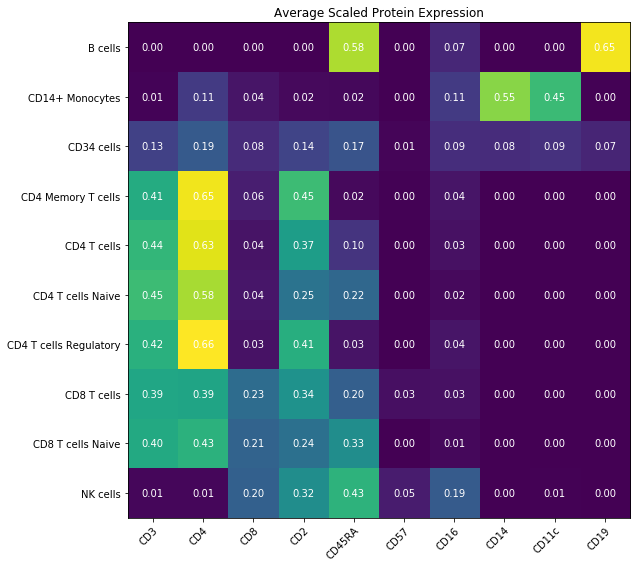

In [65]:
markers = ['CD3', 'CD4', 'CD8', 'CD2', 'CD45RA', 'CD57', 'CD16', 'CD14', 'CD11c', 'CD19']
def Heatmap(matrix, rownames,colnames,title,filename):
    fig, ax = plt.subplots(figsize=(9,8))
    # We want to show all ticks...
    im = ax.imshow(matrix,aspect='auto')
    ax.set_xticks(np.arange(len(rownames)))
    ax.set_yticks(np.arange(len(colnames)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(rownames)
    ax.set_yticklabels(colnames)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for i in range(len(colnames)):
        for j in range(len(rownames)):
            text = ax.text(j, i, "{:.2f}".format(matrix[i, j]),
                           ha="center", va="center", color="w")
    ax.set_title(title)
    fig.tight_layout()
    plt.savefig(filename, transparency=True)


Heatmap(protein,markers, celltypes2[celltype_order],'Average Scaled Protein Expression','figures/heatmap_pure_CITE.pdf')


In [66]:
from sklearn.neighbors import NearestNeighbors
# 10 nearest neighbor in citeseq from each cell in pure population
nbrs = NearestNeighbors(n_neighbors=3 + 1).fit(latent_scanvi[sample][batch_s==0,:])
indices = nbrs.kneighbors(latent_scanvi[sample][batch_s==2,:], return_distance=False)[:, 1:]

In [67]:
celltypes2 = keys[np.unique(label_s[batch_s==2])]
celltype_order = np.argsort(celltypes2)

In [68]:
protein=[]
for j in np.unique(label_s[batch_s==2])[celltype_order]:
    idx = indices[label_s[batch_s==2] == j]
    clr = normalized_protein[idx.ravel()]
    protein.append(np.mean(clr,axis=0))

protein = np.asarray(protein)

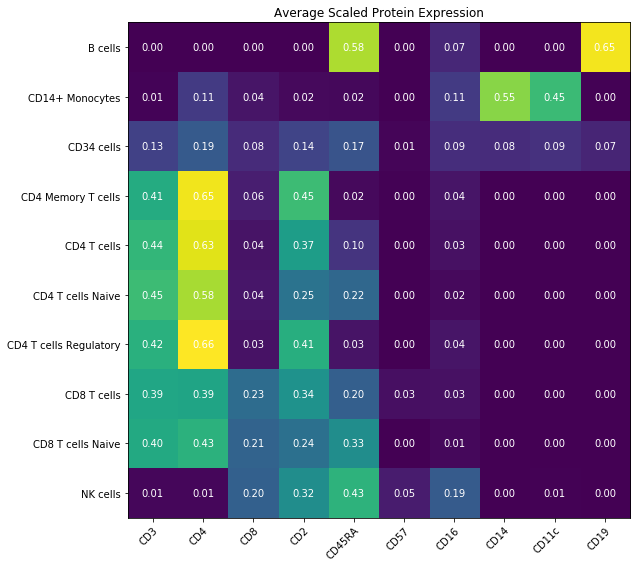

In [69]:
Heatmap(protein,markers, celltypes2[celltype_order],'Average Scaled Protein Expression','figures/heatmap_pure_CITE_SCANVI.pdf')


In [70]:
latent_cca = pd.read_csv('../CiteDonorPure/PureDonorCite.CCA.txt',sep=' ',header=None)
latent_cca = np.asarray(latent_cca)

In [71]:
cca_cells = pd.read_csv('../CiteDonorPure/PureDonorCite.CCA.cells.txt',sep=' ',header=None)
cca_cells = np.asarray(cca_cells)

In [72]:
sampled_indices = np.concatenate([np.where(batch_indices==0)[0][cca_cells[cca_cells[:,0]==0,1]-1],
                                 np.where(batch_indices==1)[0][cca_cells[cca_cells[:,0]==1,1]-1],
                                 np.where(batch_indices==2)[0][cca_cells[cca_cells[:,0]==2,1]-1]])

In [73]:
batch_cca = batch_indices[sampled_indices]
label_cca = labels[sampled_indices]

In [74]:
from scvi.metrics.clustering import select_indices_evenly
from sklearn.manifold import TSNE
import seaborn as sns

citeidx = np.arange(len(batch_cca))[batch_cca==0]
sample = np.unique(np.concatenate([select_indices_evenly(2000, label_cca),np.arange(len(batch_cca))[batch_cca==0]]))

colors = sns.color_palette('tab20')
latent_s = latent_cca[sample, :]
label_s = label_cca[sample]
batch_s = batch_cca[sample]


In [75]:
latent_s.shape

(19184, 10)

In [76]:
latent_u = UMAP(spread=2).fit_transform(latent_s)


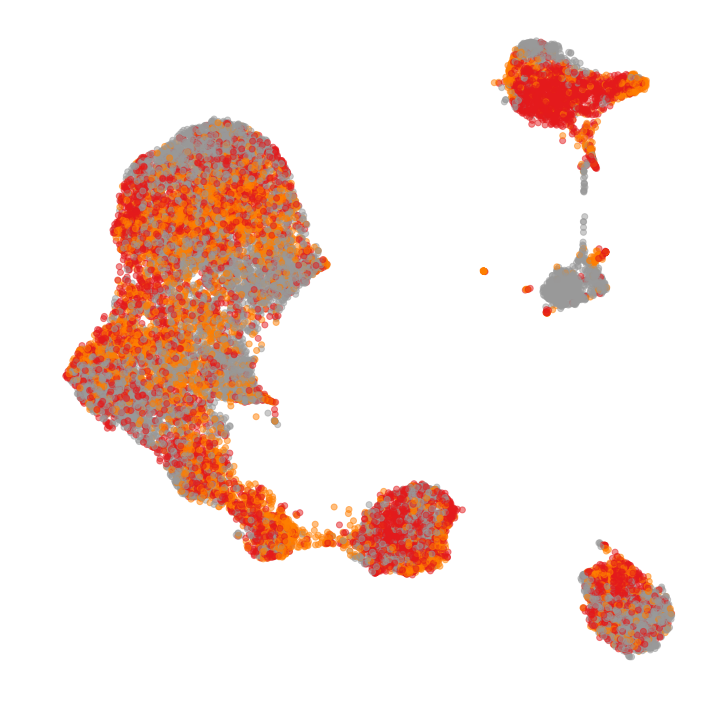

In [77]:
fig=plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
label_list = ["PBMC-CITE", "PBMC-68K", "PBMC-Pure"]
ind = np.random.permutation(np.arange(latent_u.shape[0]))
plt.scatter(latent_u[ind][:, 0], latent_u[ind][:, 1], c=batch_s[ind], cmap= matplotlib.cm.get_cmap('Set1'),alpha=0.5)
plt.axis("off")
plt.tight_layout()
plt.show()

No handles with labels found to put in legend.


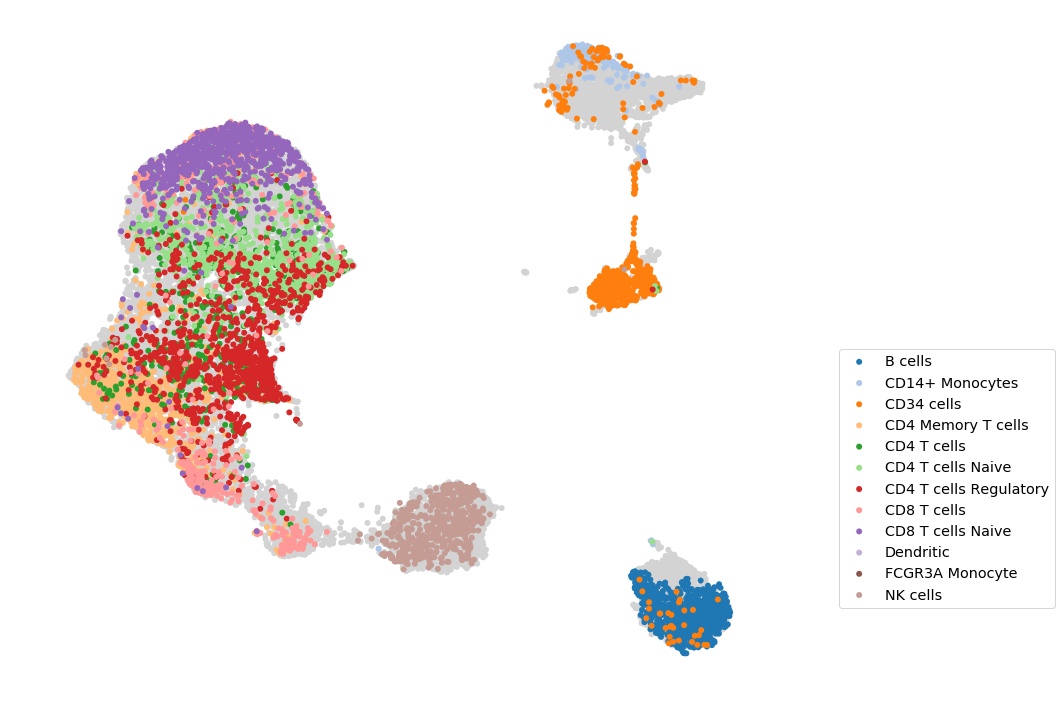

In [78]:
keys = gene_dataset.cell_types
key_order = np.argsort(keys)
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(latent_u[batch_s!=2, 0], latent_u[batch_s!=2, 1], c='lightgrey',
        edgecolors='none')
ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
for i,k in enumerate(key_order):
    if keys[k]!='unlabelled' and keys[k]!='na':
        idx = (label_s==k).astype('int') * (batch_s==2).astype('int') ==1 
        ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none')
        ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.show()

In [79]:
from sklearn.neighbors import NearestNeighbors
# 10 nearest neighbor in citeseq from each cell in pure population
nbrs = NearestNeighbors(n_neighbors=3 + 1).fit(latent_cca[batch_cca==0,:])
indices = nbrs.kneighbors(latent_cca[batch_cca==2,:], return_distance=False)[:, 1:]

In [80]:
celltypes2 = keys[np.unique(label_cca[batch_cca==2])]
celltype_order = np.argsort(celltypes2)

In [81]:
protein=[]
for j in np.unique(label_cca[batch_cca==2])[celltype_order]:
    idx = indices[label_cca[batch_cca==2] == j]
    clr = normalized_protein[idx.ravel()]
    protein.append(np.mean(clr,axis=0))

protein = np.asarray(protein)

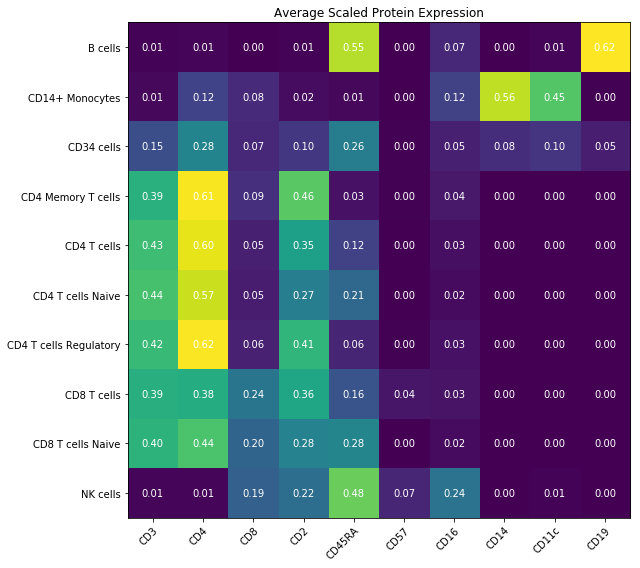

In [82]:
Heatmap(protein,markers, celltypes2[celltype_order],'Average Scaled Protein Expression','figures/heatmap_pure_CITE_CCA.pdf')

In [83]:
KNeighbors = np.concatenate([np.arange(10, 100, 10), np.arange(100, 500, 50)])

def JaccardIndex(x1,x2):
    intersection = np.sum(x1*x2)
    union = np.sum((x1+x2)>0)
    return intersection/union

def singleJaccardIndex(latent1, latent2):
    JI = []
    KNeighbors = np.concatenate([np.arange(10, 100, 10), np.arange(100, 500, 50)])
    for nn in KNeighbors:
        knn = NearestNeighbors(n_neighbors=nn, algorithm='auto')
        nbrs1 = knn.fit(latent1)
        nbrs1 = nbrs1.kneighbors_graph(latent1).toarray()
        np.fill_diagonal(nbrs1,0)
        nbrs2 = knn.fit(latent2)
        nbrs2 = nbrs2.kneighbors_graph(latent2).toarray()
        np.fill_diagonal(nbrs2,0)
        res = [JaccardIndex(x1, x2) for x1, x2 in zip(nbrs1, nbrs2)]
        JI.append(np.mean(res))
    return(JI)

In [84]:
vaeJI = singleJaccardIndex(normalized_protein, latent[batch_indices==0])

In [85]:
scanviJI = singleJaccardIndex(normalized_protein,latent_scanvi[batch_indices==0])

In [86]:
ccaJI = singleJaccardIndex(normalized_protein, latent_cca[batch_cca==0])

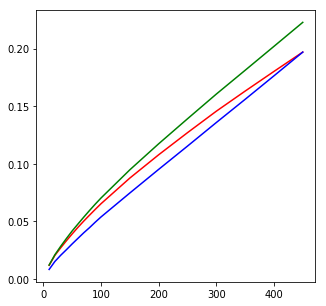

In [123]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(KNeighbors, vaeJI,'red',label='scVI')
plt.plot(KNeighbors, scanviJI,'green',label='scanVI')
plt.plot(KNeighbors, ccaJI,'blue',label='Seurat Alignment')
# legend = plt.legend(loc='upper right', shadow=False)
plt.savefig("figures/protein.KNN.pdf")


In [88]:
def ProteinDiff(normalized_protein,latent):
    res = []
    KNeighbors = np.concatenate([np.arange(10, 100, 10), np.arange(100, 500, 50)])
    for nn in KNeighbors:
        knn = NearestNeighbors(n_neighbors=nn, algorithm='auto')
        nbrs = knn.fit(latent)
        nbrs = nbrs.kneighbors_graph(latent).toarray()
        np.fill_diagonal(nbrs,0)
        diff=[]
        for i,x in enumerate(nbrs):
            diff.append(np.sum(normalized_protein[i]-np.mean(normalized_protein[np.where(x>0)],axis=0) **2))
        res.append(np.sum(diff))
    return(res)

In [89]:
vae_protdiff = ProteinDiff(normalized_protein, latent[batch_indices==0])

scanvi_protdiff = ProteinDiff(normalized_protein,latent_scanvi[batch_indices==0])

cca_protdiff = ProteinDiff(normalized_protein, latent_cca[batch_cca==0])

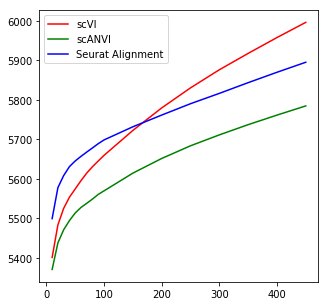

In [120]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(KNeighbors, vae_protdiff,'red',label='scVI')
plt.plot(KNeighbors, scanvi_protdiff,'green',label='scANVI')
plt.plot(KNeighbors, cca_protdiff,'blue',label='Seurat Alignment')
legend = plt.legend(loc='upper left', shadow=False)
plt.savefig("figures/protein.dist.pdf")


In [91]:
-(1/3)*np.log(1/3)*3

1.0986122886681096

In [92]:

def BE3(latent_space, batches, n_neighbors=50, n_pools=50, n_samples_per_pool=100):
    def entropy(hist_data):
        n_batches = len(np.unique(hist_data))
        freq1 = frequency = np.mean(hist_data == 1)
        freq2 = frequency = np.mean(hist_data == 2)
        freq0 = frequency = np.mean(hist_data == 0)
        if freq0 == 1 or freq1 == 1 or freq2==1:
            return 0
        elif freq0==0:
            return (- freq1) * np.log(freq1)+ (-freq2) * np.log(freq2)
        elif freq1==0:
            return (- freq0) * np.log(freq0)+ (-freq2) * np.log(freq2)
        elif freq2==0:
            return (- freq1) * np.log(freq1)+ (-freq0) * np.log(freq0)
        else:
            return (-freq0) * np.log(freq0) + (- freq1) * np.log(freq1)+ (-freq2) * np.log(freq2)

    nne = NearestNeighbors(n_neighbors=1 + n_neighbors)
    nne.fit(latent_space)
    kmatrix = nne.kneighbors_graph(latent_space) - scipy.sparse.identity(latent_space.shape[0])

    score = 0
    for t in range(n_pools):
        indices = np.random.choice(np.arange(latent_space.shape[0]), size=n_samples_per_pool)
        score += np.mean([entropy(batches[kmatrix[indices].nonzero()[1]\
            [kmatrix[indices].nonzero()[0] == i]]) for i in range(n_samples_per_pool)])
    return score / float(n_pools)


In [93]:
gene_dataset.cell_types

array(['CD8 T cells Naive', 'B cells', 'CD4 T cells Naive', 'CD4 T cells',
       'na', 'CD34 cells', 'NK cells', 'FCGR3A Monocyte',
       'CD4 Memory T cells', 'Dendritic', 'CD4 T cells Regulatory',
       'CD14+ Monocytes', 'CD8 T cells'], dtype='<U22')

In [94]:
CD34_idx = [i for i,x in enumerate(gene_dataset.cell_types) if x =='CD34 cells']

In [95]:
sample_idx = select_indices_evenly(6000,batch_indices)

In [96]:
KNeighbors = np.concatenate([np.arange(10, 100, 10), np.arange(100, 500, 50)])
vae_BE = [BE3(latent[sample_idx,:][labels[sample_idx]!=7,:],batch_indices[sample_idx][labels[sample_idx]!=7],n_neighbors=k) for k in KNeighbors]

In [97]:
scanvi_BE = [BE3(latent_scanvi[sample_idx,:],batch_indices[sample_idx],n_neighbors=k) for k in KNeighbors]

In [98]:
sample_idx = select_indices_evenly(6000,batch_cca)

In [99]:
cca_BE = [BE3(latent_cca[sample_idx,:],batch_cca[sample_idx],n_neighbors=k) for k in KNeighbors]

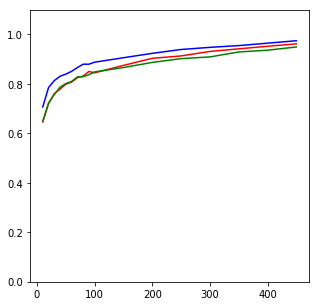

In [122]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(KNeighbors, vae_BE,'red',label='scVI')
plt.plot(KNeighbors, scanvi_BE,'green',label='scANVI')
plt.plot(KNeighbors, cca_BE,'blue',label='Seurat Alignment')
plt.ylim(0,1.0986122886681096)
# legend = plt.legend(loc='lower right', shadow=False)
plt.savefig("figures/CitePureDonorBE.dist.pdf")
